## EIIE with SEC Sentiment Data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy.typing as npt
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from importlib import reload

from portfolio_env_framework import *
from data_utils import *
from rewards import *

In [2]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(7, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
        news_df = read_news_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))

    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
        news_df = news_df[news_df.apply(lambda row: (row.ticker in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
        news_sentiment_array = news_df.pivot(index='date', columns='ticker', values= 'sentiment_embedding').astype(float)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sent_df = news_sentiment_array
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((7, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[6, :, : ] = self.news_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [3]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(7, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
        news_df = read_news_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
        news_df = news_df[news_df.apply(lambda row: (row.ticker in self.tickers), axis=1)]
        
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
        news_sentiment_array = news_df.pivot(index='date', columns='ticker', values= 'sentiment_embedding').astype(float)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sent_df = news_sentiment_array

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((7, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[6, :, : ] = self.news_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

## CNN

In [5]:
class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 1028):
        super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 6, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(6, 8, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(10, 12, kernel_size=(1, data_len-6)),
        )

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        x = self.cnn(observations['data'])
        return torch.cat((x.flatten(start_dim=1), observations['weights'].flatten(start_dim=1)), dim=1)

In [6]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_CNN_Extractor,
}, action_noise=NormalActionNoise(mean=0, sigma=0.05*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 18.08GB > 3.48GB
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [6]:
model.save("ds_sec_model")

In [9]:
model.load('cnn_sec_and_news_model_gcloud.zip')

/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object policy_kwargs. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from '/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from '/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/sta

RuntimeError: Error(s) in loading state_dict for MultiInputPolicy:
	Unexpected key(s) in state_dict: "actor.features_extractor.cnn.0.weight", "actor.features_extractor.cnn.0.bias", "actor.features_extractor.cnn.2.weight", "actor.features_extractor.cnn.2.bias", "actor.features_extractor.cnn.4.weight", "actor.features_extractor.cnn.4.bias", "actor.features_extractor.cnn.6.weight", "actor.features_extractor.cnn.6.bias", "actor_target.features_extractor.cnn.0.weight", "actor_target.features_extractor.cnn.0.bias", "actor_target.features_extractor.cnn.2.weight", "actor_target.features_extractor.cnn.2.bias", "actor_target.features_extractor.cnn.4.weight", "actor_target.features_extractor.cnn.4.bias", "actor_target.features_extractor.cnn.6.weight", "actor_target.features_extractor.cnn.6.bias", "critic.features_extractor.cnn.0.weight", "critic.features_extractor.cnn.0.bias", "critic.features_extractor.cnn.2.weight", "critic.features_extractor.cnn.2.bias", "critic.features_extractor.cnn.4.weight", "critic.features_extractor.cnn.4.bias", "critic.features_extractor.cnn.6.weight", "critic.features_extractor.cnn.6.bias", "critic_target.features_extractor.cnn.0.weight", "critic_target.features_extractor.cnn.0.bias", "critic_target.features_extractor.cnn.2.weight", "critic_target.features_extractor.cnn.2.bias", "critic_target.features_extractor.cnn.4.weight", "critic_target.features_extractor.cnn.4.bias", "critic_target.features_extractor.cnn.6.weight", "critic_target.features_extractor.cnn.6.bias". 
	size mismatch for actor.mu.0.weight: copying a param with shape torch.Size([400, 1028]) from checkpoint, the shape in current model is torch.Size([400, 5610]).
	size mismatch for actor_target.mu.0.weight: copying a param with shape torch.Size([400, 1028]) from checkpoint, the shape in current model is torch.Size([400, 5610]).
	size mismatch for critic.qf0.0.weight: copying a param with shape torch.Size([400, 1108]) from checkpoint, the shape in current model is torch.Size([400, 5690]).
	size mismatch for critic_target.qf0.0.weight: copying a param with shape torch.Size([400, 1108]) from checkpoint, the shape in current model is torch.Size([400, 5690]).

In [32]:
env = PortfolioEnvWithTCost(
    dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)


self.universe_size=79


In [ ]:

env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
    'dm': TestDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

In [9]:
port_val

[1.0,
 0.9902564102564103,
 0.9897612003499294,
 0.9925970016946128,
 0.9815360825798393,
 0.9663108978962426,
 0.9744810629717541,
 0.9682239759475546,
 0.9700275541449819,
 0.9552878245661304,
 0.961833370536258,
 0.9799809332058868,
 0.9910180477414103,
 0.992298118998036,
 0.9868709490866465,
 0.9932310981506558,
 0.9950841072180951,
 1.0011763720419813,
 1.000193353325127,
 1.0015992213346845,
 0.9993255171885117,
 1.0027220090057487,
 1.0022353590473057,
 0.9935334515674514,
 0.9622494592620114,
 0.9346033897299063,
 0.9307411943876674,
 0.8939542963789957,
 0.8847957592367119,
 0.9247756527506487,
 0.8973402679992366,
 0.9322676667821016,
 0.9024121084198631,
 0.8928565174433278,
 0.825436333388304,
 0.8684078053366883,
 0.8312065233578162,
 0.7505418203995556,
 0.8182393184519585,
 0.7273300308595912,
 0.7752518537178673,
 0.7414918419478449,
 0.7487778709378378,
 0.7113550244541104,
 0.6993458304075362,
 0.7573015505370914,
 0.7671338545377814,
 0.809619002541087,
 0.787995618

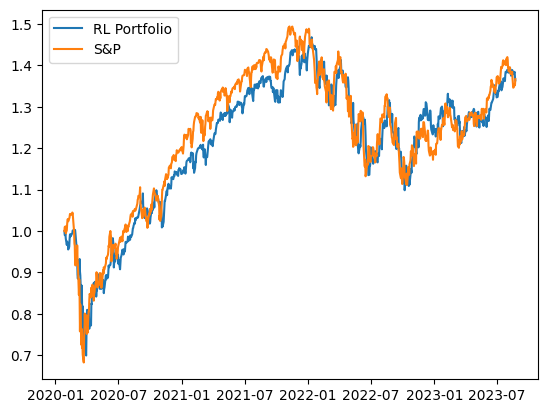

In [8]:
# sec_model
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

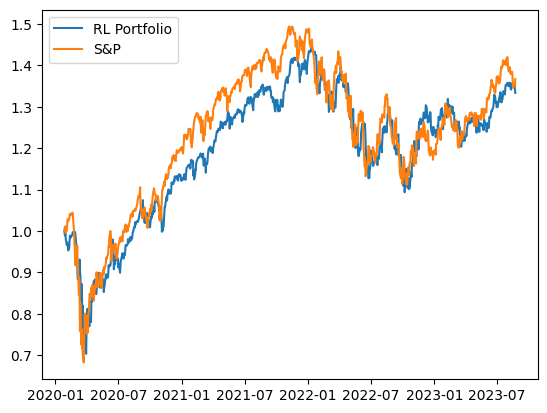

In [16]:
# std=0.05, gamma=1-1/5, train 30min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

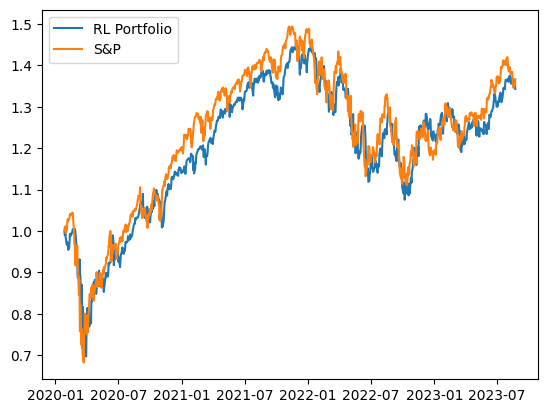

In [12]:
# std=0.04, gamma=1-1/5, train 20min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

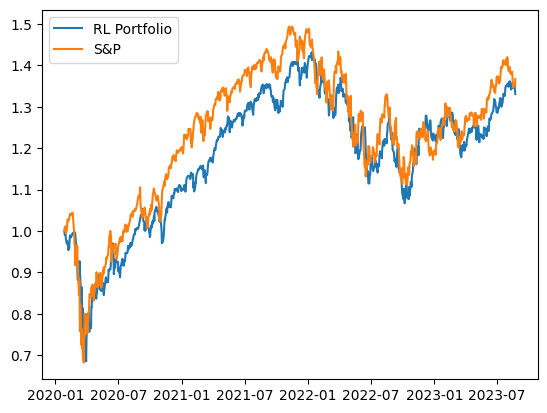

In [9]:
# std=0.03, gamma=1-1/5, train 10min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

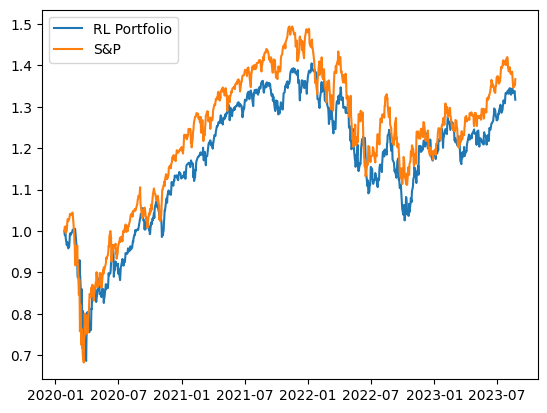

In [9]:
# std=0.02, gamma=1-1/5, train 15min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

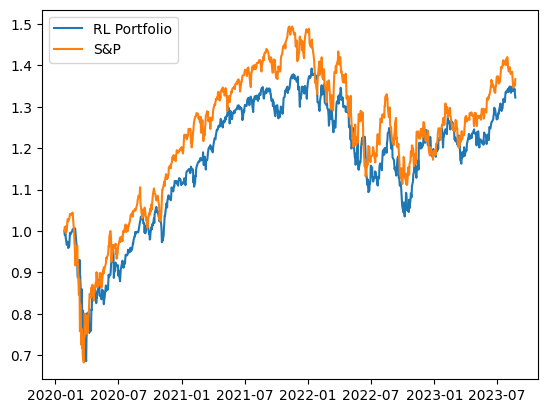

In [9]:
# std=0.02, gamma=1-1/30, train 20min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

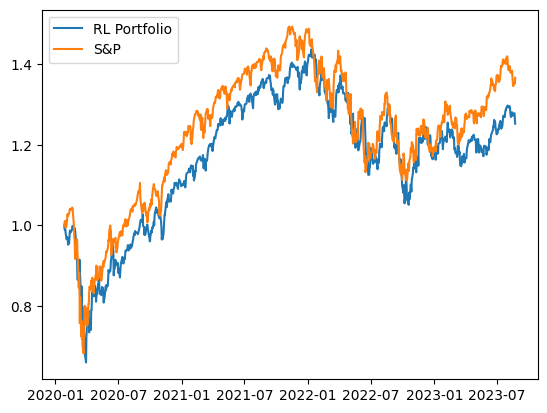

In [37]:
# actual sec, training 20m, std=0.01
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

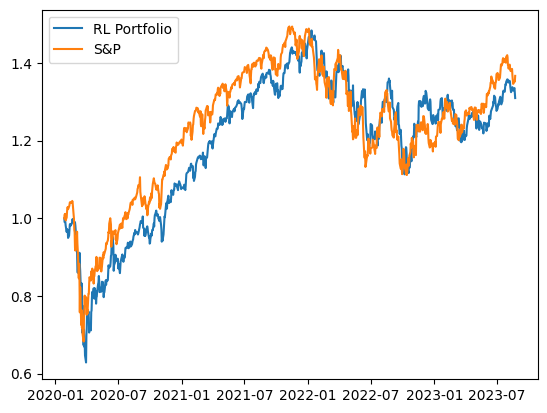

In [34]:
# actual sec, training 10m, std=0.02, slightly larger buffer
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

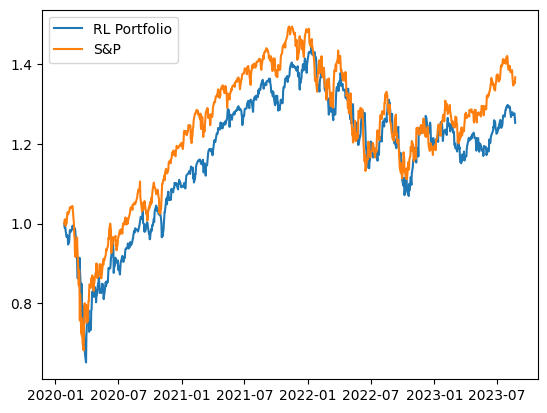

In [31]:
# actual sec, training 10m, std=0.03
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

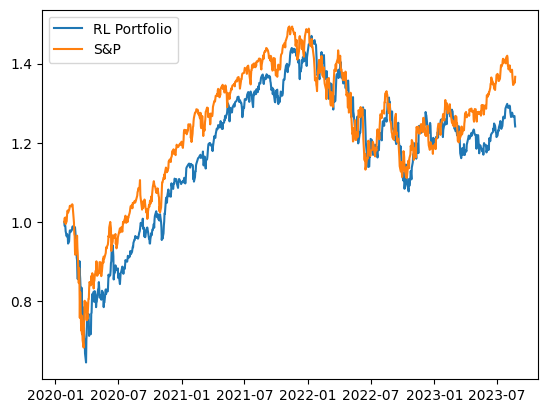

In [28]:
# actual sec, training 15m, std=0.05 (please work??)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

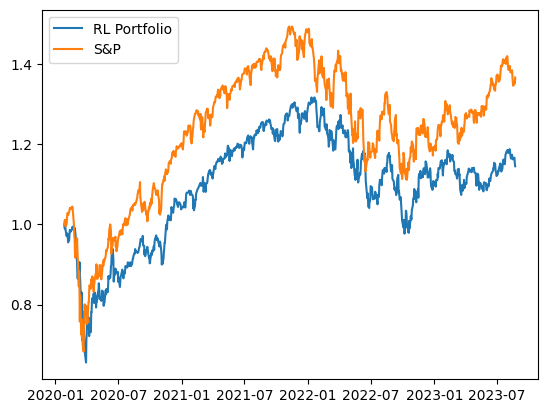

In [20]:
# actual sec, training 20m, std=0.1
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

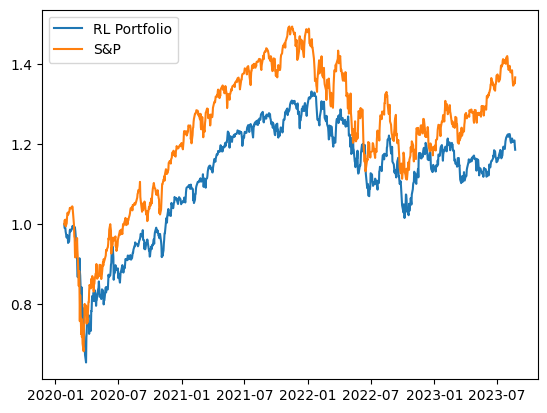

In [17]:
# actual sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

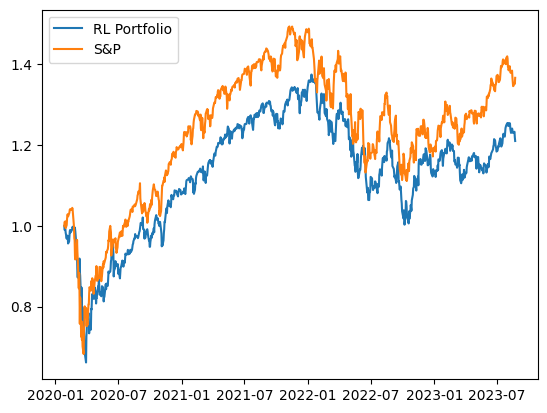

In [12]:
# sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

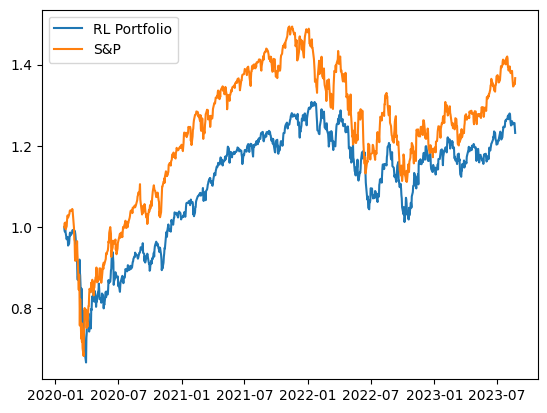

In [19]:
# basic, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

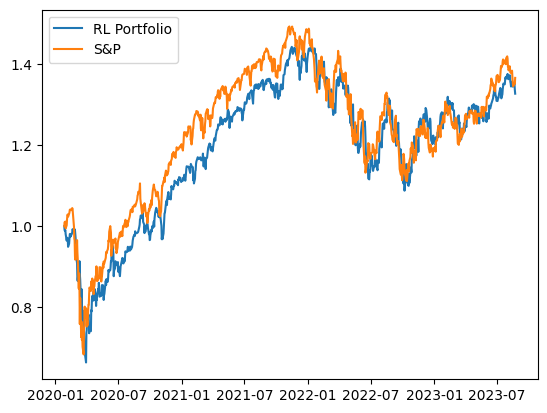

In [16]:
# basic, 15min training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## RNN

In [46]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class Custom_EIEE_RNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 1344):
        super(Custom_EIEE_RNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        self.lstm = nn.LSTM(input_size=6, hidden_size=16, batch_first=True).cuda()

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        # assert len(observations['data'].shape) == 4 # (4, 3, 85, 100)
        obs = torch.permute(observations['data'], (0, 2, 3, 1)) # (4, 85, 100, 3)
        obs = obs.flatten(0, 1)
        x = self.lstm(obs)
        y = x[1][-1].squeeze()
        z = y.unflatten(0, (y.shape[0] // self.universe_size, self.universe_size))
        return torch.cat((z.squeeze(-1).flatten(1), observations['weights']), dim=1)

In [50]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=3*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_RNN_Extractor,
}, action_noise=NormalActionNoise(mean=0, sigma=0.03*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.264    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 21       |
|    time_elapsed    | 115      |
|    total_timesteps | 2499     |
| train/             |          |
|    actor_loss      | 0.102    |
|    critic_loss     | 5.22e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 2398     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.844    |
| time/              |          |
|    episodes        | 2        |
|    fps             | 22       |
|    time_elapsed    | 224      |
|    total_timesteps | 4998     |
| train/             |          |
|    actor_loss      | 0.0837   |

KeyboardInterrupt: 

In [53]:
model.save('ds_sec_model_rnn')

In [51]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


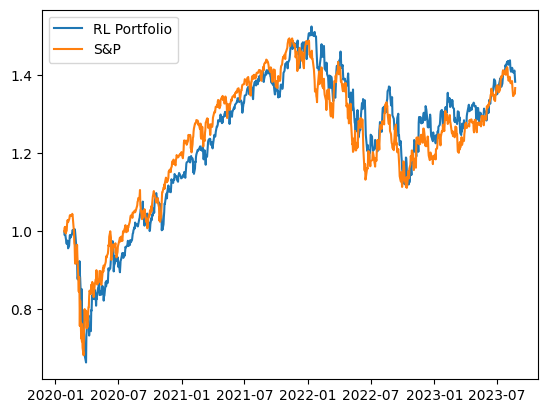

In [52]:
# std=0.03
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

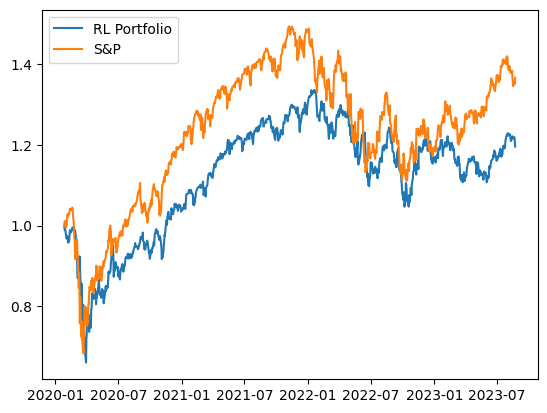

In [49]:
# standard
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## MLP

In [8]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=3*10**5, verbose=1, policy_kwargs={
}, action_noise=NormalActionNoise(mean=0, sigma=0.02*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.244    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 34       |
|    time_elapsed    | 73       |
|    total_timesteps | 2499     |
| train/             |          |
|    actor_loss      | 0.619    |
|    critic_loss     | 5.34e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 2398     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.85     |
| time/              |          |
|    episodes        | 2        |
|    fps             | 33       |
|    time_elapsed    | 149      |
|    total_timesteps | 4998     |
| train/             |          |
|    actor_loss      | 0.555    |

KeyboardInterrupt: 

In [7]:
model.save('ds_sec_model_mlp')

In [9]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


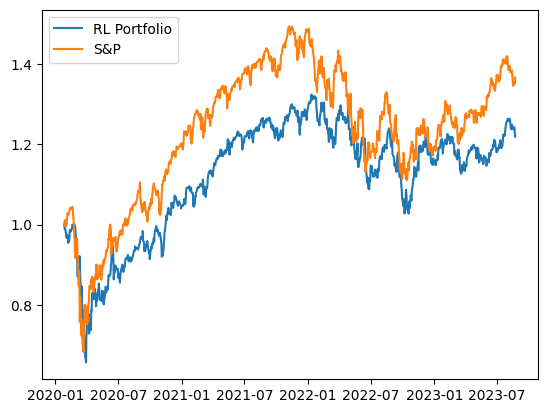

In [6]:
# std=0.03, 20min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Combined Plot

In [12]:
cnn_model = DDPG.load('sec_model')
rnn_model = DDPG.load('sec_model_rnn')
mlp_model = DDPG.load('sec_model_mlp')

In [13]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)

models = [cnn_model, rnn_model, mlp_model]
port_vals = []

for model in models:
  obs, _ = env.reset()

  port_val = [1.0]
  snp_val = [1.0]
  actions = []
  ys = []
  times_arr = [env.dm.times[env.t+15]]
  mus = []

  for i in range(900):
      action, _ = model.predict(obs, deterministic=True)
      actions.append(action)
      # print(f"external {action=}")
      obs, rewards, terminated, truncated, info = env.step(action)
      ys.append(env.y)
      mus.append(env.mu)
      times_arr.append(env.dm.times[env.t+15])
      port_val.append(info['port_val'])
      snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
      if terminated:
          break
  
  port_vals.append(port_val)

self.universe_size=79


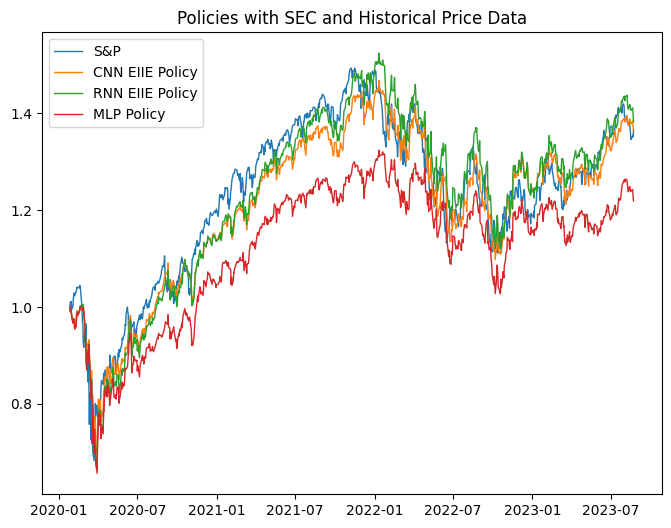

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(times_arr, np.array(snp_val), label='S&P', lw=1)
plt.plot(times_arr, np.array(port_vals[0]), label='CNN EIIE Policy', lw=1)
plt.plot(times_arr, np.array(port_vals[1]), label='RNN EIIE Policy', lw=1)
plt.plot(times_arr, np.array(port_vals[2]), label='MLP Policy', lw=1)
# plt.yscale('log')
plt.legend()
plt.title('Policies with SEC and Historical Price Data')
plt.show()

In [26]:
df = read_crsp_data()
full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
news_df = read_news_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))


# only include stocks that are present in all dates and in both datasets
df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
def is_max_val_count(ticker: str) -> bool:
    return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
times = df.date.unique()[1:]
tickers = df.TICKER.unique()
full_df = full_df[full_df.apply(lambda row: (row.TICKERH in tickers), axis=1)]
news_df = news_df[news_df.apply(lambda row: (row.ticker in tickers), axis=1)]

0       0.037281
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5841         NaN
5842         NaN
5843         NaN
5844         NaN
5845    0.010191
Name: AAPL, Length: 5846, dtype: float64
5846    0.015532
5847         NaN
5848         NaN
5849         NaN
5850         NaN
          ...   
9730         NaN
9731         NaN
9732         NaN
9733         NaN
9734    0.018307
Name: ABBV, Length: 3889, dtype: float64
9735     0.018966
9736          NaN
9737          NaN
9738          NaN
9739          NaN
           ...   
15465         NaN
15466         NaN
15467         NaN
15468         NaN
15469    0.014586
Name: ABT, Length: 5735, dtype: float64
15470    0.017032
15471         NaN
15472         NaN
15473         NaN
15474         NaN
           ...   
20733         NaN
20734         NaN
20735         NaN
20736         NaN
20737    0.014191
Name: ACN, Length: 5268, dtype: float64
20738    0.013713
20739         NaN
20740         NaN
20741         

In [27]:
# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
high_df = high_df * (1+facpr_df).cumprod(axis=0)
low_df = low_df * (1+facpr_df).cumprod(axis=0)
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

# create pivot tables
neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
news_sentiment_array = news_df.pivot(index='date', columns='ticker', values= 'sentiment_embedding').astype(float)
no_sentiment_tickers = list(set(tickers) - set(news_sentiment_array.columns.values))

news_sentiment_array[[no_sentiment_tickers]] = 0
news_sent_df = news_sentiment_array

In [28]:
num_time_periods = len(times)-15-1
universe_size = len(tickers)

In [29]:
t = 0
s = np.zeros((7, universe_size, 10))
s[0, :, :] = stock_df.loc[times[t:t+10], tickers].to_numpy().T
s[1, :, :] = high_df.loc[times[t:t+10], tickers].to_numpy().T
s[2, :, :] = low_df.loc[times[t:t+10], tickers].to_numpy().T
s[3, :, :] = neg_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[4, :, :] = pos_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[5, :, :] = unc_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[6, :, : ] = news_sent_df.loc[times[t:t+10], tickers].to_numpy().T

In [30]:
s

array([[[2.48200000e+01, 2.44600000e+01, 2.43800000e+01, ...,
         2.53400000e+01, 2.52400000e+01, 2.53300000e+01],
        [3.09600000e+01, 3.07700000e+01, 3.04520000e+01, ...,
         3.09600000e+01, 3.08600000e+01, 3.11000000e+01],
        [4.04300000e+01, 4.04300000e+01, 4.12100000e+01, ...,
         4.25700000e+01, 4.26300000e+01, 4.28500000e+01],
        ...,
        [4.89200000e+01, 4.89200000e+01, 4.95300000e+01, ...,
         4.96000000e+01, 4.96200000e+01, 5.00900000e+01],
        [8.71300000e+01, 8.59600000e+01, 8.67600000e+01, ...,
         8.74400000e+01, 8.61400000e+01, 8.78500000e+01],
        [3.14800000e+01, 3.17900000e+01, 3.30100000e+01, ...,
         3.33200000e+01, 3.37500000e+01, 3.51300000e+01]],

       [[2.48500000e+01, 2.49150000e+01, 2.46100000e+01, ...,
         2.55800000e+01, 2.56400000e+01, 2.55000000e+01],
        [3.11000000e+01, 3.10800000e+01, 3.07000000e+01, ...,
         3.11000000e+01, 3.12400000e+01, 3.12400000e+01],
        [4.04600000e+01, 

In [19]:
model.load('tcost_portfolio_rl_model_framework_200_news.zip')

/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 164.83GB > 6.15GB
  warnings.warn(


AttributeError: 'ActorCriticPolicy' object has no attribute 'actor'

In [33]:
custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
            "policy_kwargs":
            {
                'features_extractor_class': Custom_EIEE_CNN_Extractor
                }
        }

model = DDPG.load('cnn_sec_and_news_model_gcloud', custom_objects=custom_objects, env = env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 18.08GB > 5.35GB
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for MultiInputPolicy:
	Missing key(s) in state_dict: "critic.qf1.0.weight", "critic.qf1.0.bias", "critic.qf1.2.weight", "critic.qf1.2.bias", "critic.qf1.4.weight", "critic.qf1.4.bias", "critic_target.qf1.0.weight", "critic_target.qf1.0.bias", "critic_target.qf1.2.weight", "critic_target.qf1.2.bias", "critic_target.qf1.4.weight", "critic_target.qf1.4.bias". 